In [40]:
import numpy as np
from scipy import stats
import pymc as pm
from pymc.sampling.jax import sample_numpyro_nuts
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pytensor 
%matplotlib inline

観測方程式
$$ y_t = h(x_t) + \epsilon_t $$
状態方程式
$$ x_t = f(x_{t-1}) + \xi_t $$


例
$$
y_t = x_t + \epsilon_t \\
x_t = ax_{t-1} + \xi_t \\
$$

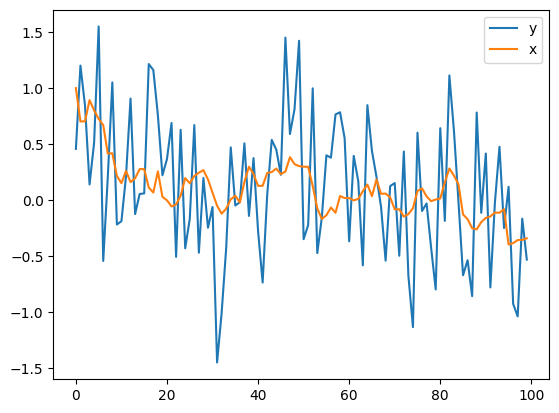

In [41]:
# データの生成、真の値の設定
np.random.seed(123)
num = 100
a_real = 0.9
x0_real = 1
epsilon = np.random.normal(0, 0.5, num)
xi = np.random.normal(0, 0.1, num)
x_real = np.zeros(num)
y = np.zeros(num)
x_real[0] = x0_real
y[0] = x0_real + epsilon[0]

for t in range(1, num):
    x_real[t] = a_real*x_real[t-1] + xi[t]
    y[t] = x_real[t] + epsilon[t]

plt.plot(y)
plt.plot(x_real)
plt.legend(['y', 'x'])

In [42]:
def fn(xi, x, a):
    return a*x + xi

In [43]:
with pm.Model() as model:
    sigma_xi = pm.HalfFlat('sigma_xi')
    a = pm.Flat('a')
    x0 = pm.Normal('x0', mu=1, sigma=sigma_xi)
    xi = pm.Normal('xi', mu=0, sigma=sigma_xi, shape=num)

    results, _ = pytensor.scan(fn, outputs_info=x0, sequences=[xi], non_sequences=[a])
    x = pm.Deterministic('x', results)

    sigma_eps = pm.HalfFlat('sigma_eps')
    likelihood = pm.Normal('y', mu=x, sigma=sigma_eps, observed=y)

In [44]:
with model:
    trace = sample_numpyro_nuts(5000)

Compiling...
Compilation time =  0:00:02.531057
Sampling...


Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]








Running chain 0:   0%|          | 0/6000 [00:04<?, ?it/s]


Running chain 0:  10%|█         | 600/6000 [00:04<00:01, 3967.43it/s]


Running chain 0:  20%|██        | 1200/6000 [00:04<00:01, 4233.28it/s]


Running chain 0:  35%|███▌      | 2100/6000 [00:04<00:00, 5277.64it/s]

Running chain 0:  45%|████▌     | 2700/6000 [00:04<00:00, 5332.49it/s]


Running chain 0:  55%|█████▌    | 3300/6000 [00:04<00:00, 5473.18it/s]


Running chain 0:  65%|██████▌   | 3900/6000 [00:04<00:00, 4941.12it/s]


Running chain 3: 100%|██████████| 6000/6000 [00:06<00:00, 871.51it/s] 


Sampling time =  0:00:07.135688
Transforming variables...
Transformation time =  0:00:00.509257


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'x0'}>],
       [<Axes: title={'center': 'xi'}>, <Axes: title={'center': 'xi'}>],
       [<Axes: title={'center': 'sigma_xi'}>,
        <Axes: title={'center': 'sigma_xi'}>],
       [<Axes: title={'center': 'sigma_eps'}>,
        <Axes: title={'center': 'sigma_eps'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

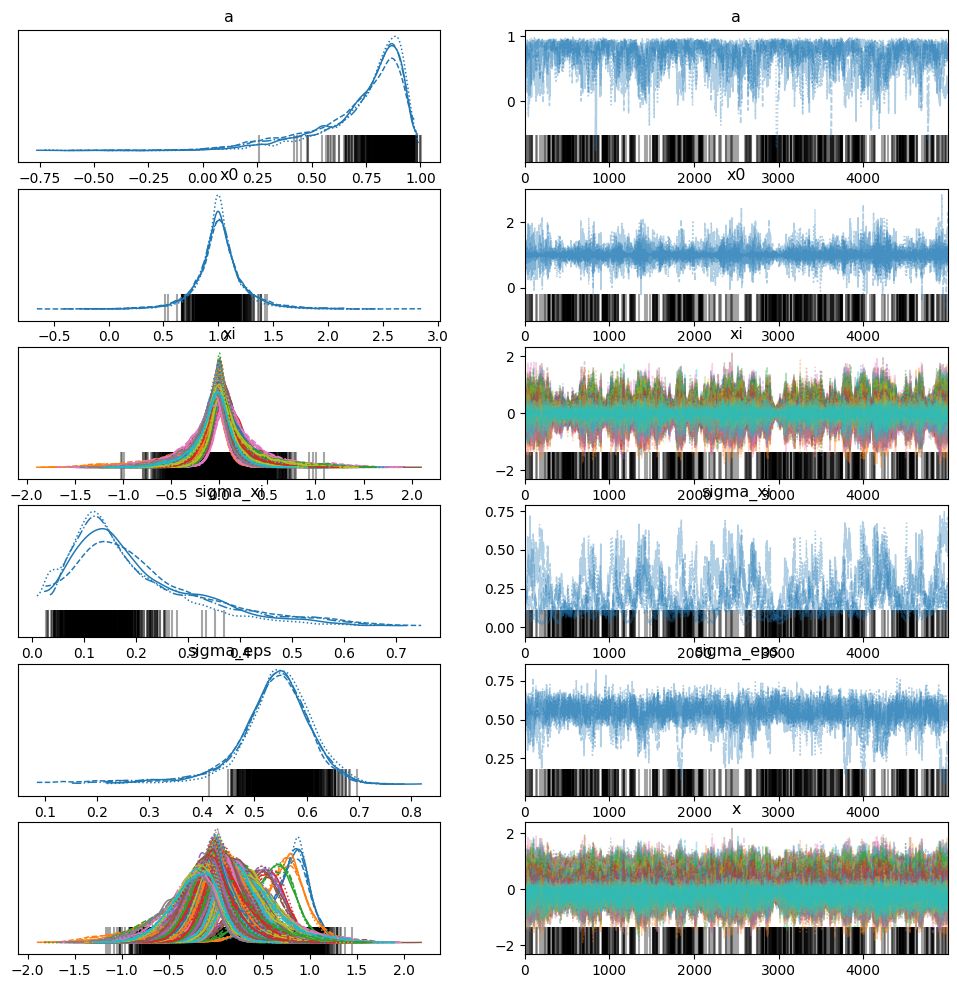

In [45]:
pm.plot_trace(trace)

In [46]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.726,0.209,0.314,0.972,0.011,0.008,341.0,917.0,1.01
x0,1.014,0.225,0.595,1.480,0.002,0.002,18376.0,2030.0,1.01
xi[0],0.033,0.189,-0.304,0.442,0.003,0.004,6058.0,2284.0,1.01
xi[1],0.141,0.271,-0.269,0.735,0.013,0.009,639.0,709.0,1.01
xi[2],0.063,0.209,-0.289,0.519,0.006,0.005,1778.0,1154.0,1.01
...,...,...,...,...,...,...,...,...,...
x[95],-0.132,0.224,-0.580,0.280,0.003,0.003,5097.0,3273.0,1.00
x[96],-0.288,0.268,-0.840,0.158,0.011,0.008,660.0,1371.0,1.01
x[97],-0.321,0.286,-0.896,0.151,0.013,0.009,516.0,1158.0,1.01
x[98],-0.220,0.239,-0.698,0.197,0.005,0.004,2395.0,7281.0,1.00


In [50]:
trace.posterior['sigma_eps'].mean()

<xarray.DataArray 'sigma_eps' ()>
array(0.53563171)

Sampling: [y]


/Users/shunta/py_venvs/py1/.venv1/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


(-1.5, 2.0)

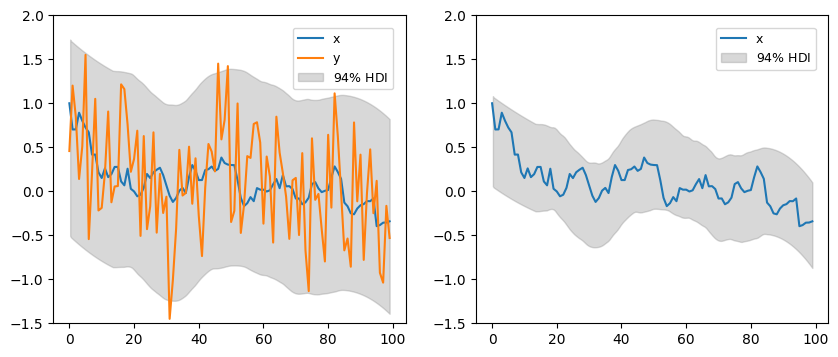

In [ ]:
pp = pm.sample_posterior_predictive(trace, model=model)
t = np.arange(0, num)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(x_real, label='x')
axL.plot(y, label='y')
pm.plot_hdi(t, pp.posterior_predictive['y'],fill_kwargs={'color': 'gray', 'alpha': 0.3, 'label': r'$94\%$ HDI'}, ax=axL)
axL.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=9)
axL.set_ylim(-1.5, 2)

axR.plot(x_real, label='x')
pm.plot_hdi(t, trace.posterior['x'][1],fill_kwargs={'color': 'gray', 'alpha': 0.3, 'label': r'$94\%$ HDI'}, ax=axR)
axR.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=9)
axR.set_ylim(-1.5, 2)

/Users/shunta/py_venvs/py1/.venv1/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


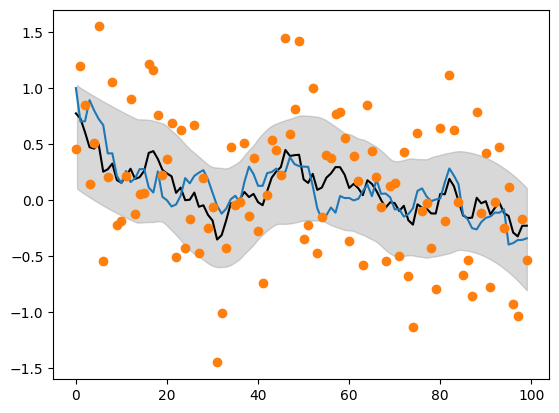

In [ ]:
pm.plot_hdi(t, trace.posterior['x'][0], fill_kwargs={'color': 'gray', 'alpha': 0.3, 'label': r'$94\%$ HDI'})
plt.plot(t, trace.posterior['x'][0].mean(axis=0), color='k', label='mean')
plt.plot(t, x_real)
plt.plot(t, y, 'o')

In [ ]:
trace.posterior['x']

<xarray.DataArray 'x' (chain: 4, draw: 5000, x_dim_0: 100)>
array([[[ 0.5114471 ,  0.51841769,  0.32698876, ..., -0.35293286,
         -0.31380896, -0.00207107],
        [ 0.62036025,  0.36310969,  0.43012534, ...,  0.19153865,
          0.35094274, -0.04294367],
        [ 0.53126006,  0.40232747,  0.28126693, ..., -0.46749123,
         -0.03895376, -0.17116464],
        ...,
        [ 0.76862073,  0.6409042 ,  0.46819811, ..., -0.2979667 ,
         -0.23159936, -0.39997875],
        [ 0.75402745,  0.50866319,  0.43521686, ...,  0.14143182,
          0.12229627,  0.28798586],
        [ 0.89194744,  0.85188198,  0.66396503, ..., -0.46787148,
         -0.45418901, -0.5808159 ]],

       [[ 0.06444256,  0.63755112,  0.50565421, ..., -0.48708819,
         -0.56051336, -0.41476099],
        [ 0.4637785 ,  1.36515796,  0.95598806, ..., -0.76530666,
         -0.56632477, -0.04489854],
        [ 0.37513828,  0.35269281,  0.42141043, ..., -0.72098992,
          0.29319718, -0.11894445],
...
        [ 0.99168236,  0.45610162,  0.31609263, ..., -0.48974502,
         -0.33701178, -0.05830567],
        [ 0.22672677,  0.57774389,  0.4972523 , ..., -0.28162809,
         -0.18810061, -0.32665388],
        [ 1.03049336,  1.0074409 ,  0.45000654, ..., -0.56628853,
         -0.28269271, -0.4099269 ]],

       [[ 0.89049781,  0.70373054,  0.62621824, ...,  0.10143833,
          0.00817776,  0.07931195],
        [ 0.85715052,  0.76989914,  0.68420433, ..., -0.19520194,
         -0.11636042, -0.19939538],
        [ 0.78886406,  0.73831733,  0.6545884 , ..., -0.06160157,
         -0.12125934, -0.19736918],
        ...,
        [ 0.88157272,  0.88189026,  0.87935397, ..., -0.20829036,
         -0.23235794, -0.20458696],
        [ 0.83678052,  0.69384035,  0.69989323, ..., -0.0935487 ,
         -0.08213415, -0.03651362],
        [ 1.00489817,  0.96409617,  0.84457088, ..., -0.27659007,
         -0.21904187, -0.26164739]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99